## 0. Setup

In [1]:
import os
from typing import Dict, Any
from IPython.display import Image, display
from dotenv import load_dotenv
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.graph.message import MessagesState
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor

In [2]:
load_dotenv()

True

In [3]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    base_url="https://openai.vocareum.com/v1",
    api_key=os.getenv("VOCAREUM_API_KEY")
)

## 1. Sub Agents

In [4]:
research_worker = create_react_agent(
    name="research_worker",
    prompt=SystemMessage(
        content=(
            "You are a research specialist. Given a topic, find key information. "
            "Return ONLY JSON with: keywords, sources."
        )
    ),
    model=llm,
    tools=[],
)

In [5]:
writing_worker = create_react_agent(
    name="writing_worker",
    prompt=SystemMessage(
        content=(
            "You are a content writer. " 
            "Given research keywords, write clear and concise content. "
            "Return ONLY JSON with: content, summary."
        )
    ),
    model=llm,
    tools=[],
)

## 2. Orchestrator

In [6]:
supervisor_agent = create_supervisor(
    model=llm,
    agents=[research_worker, writing_worker],
    prompt=SystemMessage(
        content=(
            "You are a task supervisor. When given a request:\n"
            "1. First call research_worker to gather information\n"
            "2. Then call writing_worker to create content based on the research\n"
            "3. Combine everything into a final response\n\n"
            "Call the agents in this order: research_worker → writing_worker"
        )
    ),
    add_handoff_back_messages=True,
    output_mode="last_message",
).compile()

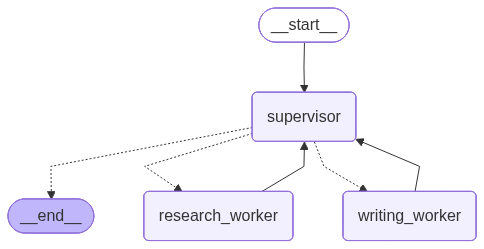

In [7]:
display(
    Image(
        supervisor_agent.get_graph().draw_mermaid_png()
    )
)

## 4. Run

In [ ]:
result = supervisor_agent.invoke(
    input={
        "messages": [
            HumanMessage(
                content="topic machine learning basics"
            )
        ]
    }
)

In [ ]:
for message in result["messages"]:
    message.pretty_print()

## 5. Hierarchical

In [ ]:
team_1 = create_supervisor(
    agents=[
        create_react_agent(name="agent_1", model=llm, tools=[]), 
        create_react_agent(name="agent_2", model=llm, tools=[]), 
    ],
    model=llm,
    supervisor_name="supervisor_1"
).compile(name="team_1")

team_2 = create_supervisor(
    agents=[
        create_react_agent(name="agent_3", model=llm, tools=[]), 
        create_react_agent(name="agent_4", model=llm, tools=[]), 
    ],
    model=llm,
    supervisor_name="supervisor_2"
).compile(name="team_2")


top_level_supervisor = create_supervisor(
    agents=[team_1, team_2],
    model=llm,
    supervisor_name="top_level_supervisor"
).compile(name="top_level_supervisor")

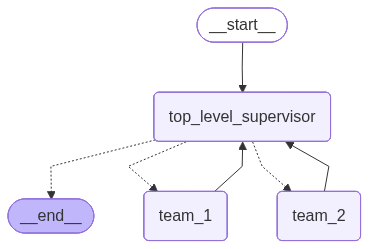

In [14]:
display(
    Image(
        top_level_supervisor.get_graph().draw_mermaid_png()
    )
)